# DGM Lab 3 - Variational Autoencoders

In this Lab, we will build and train latent variable models using the Variational Autoencoder framework.

 ## Variational Autoencoders

 A variational autoencoder consists of a likelihood model, or decoder $p_\theta(x| z)$, and an approximate posterior model, or encoder $q(z | x)$.

 ### Assignment 1

 We will build a Variational Autoencoder for modelling MNIST digits. As you recall from Lab 1, MNIST digits are 28x28 binary images of handwritten digits. Build an `Encoder` and `Decoder` class as Pytorch `nn.Module`s, which represent $q(z | x)$ and $p_\theta(x| z)$. Parameterize the latent space $z$ as a multivariate Gaussian with diagonal covariance matrix. A simple architecture will suffice, for example a 2 hidden layer fully connected neural network. For now, limit the latent space to two dimensions, so we can visualize and investigate the learnt manifold later.

 Think how to parameterize the outputs of each model. For example, a Gaussian can be parameterized by means and standard deviations, or means and variance, or mean and log variance, ... Similarly the likelihood model should model a distribution over pixels. Which distribution seems appropriate for binary pixels?

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Encoder, self).__init__()
    self.fc1 = nn.Linear(input_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.fc_mu = nn.Linear(hidden_dim, latent_dim)
    self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    mu = self.fc_mu(x)
    logvar = self.fc_logvar(x)
    return mu, logvar


class Decoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, output_dim):
    super(Decoder, self).__init__()
    self.fc1 = nn.Linear(latent_dim, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    self.fc3 = nn.Linear(hidden_dim, output_dim)

  def forward(self, z):
    z = F.relu(self.fc1(z))
    z = F.relu(self.fc2(z))
    z = torch.sigmoid(self.fc3(z))  # Output is a probability for each pixel
    return z


To test your classes, load the MNIST dataset, and forward a batch of data through the `Encoder`. Similarly, create a batch of $z$ tensors, forward these through the `Decoder` and plot the results.

100%|██████████| 9.91M/9.91M [00:00<00:00, 63.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.81MB/s]


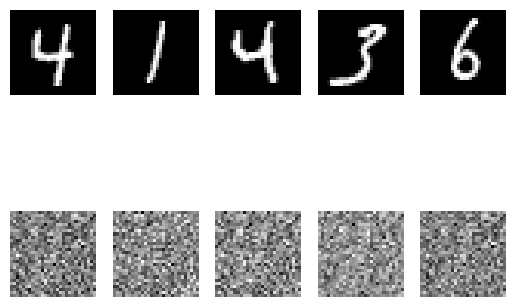

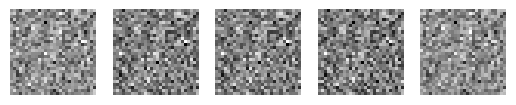

In [ ]:
import torchvision
import matplotlib.pyplot as plt

# Load MNIST dataset
transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Instantiate Encoder and Decoder
input_dim = 28 * 28
hidden_dim = 256
latent_dim = 2
encoder = Encoder(input_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, input_dim)

# Get a batch of data
data, _ = next(iter(train_loader))
data = data.view(-1, input_dim)

# Forward through the Encoder
mu, logvar = encoder(data)

# Sample z from the approximate posterior
std = torch.exp(0.5 * logvar)
eps = torch.randn_like(std)
z = mu + eps * std

# Forward through the Decoder
reconstructed_data = decoder(z)

# Plot the original and reconstructed images
num_images = 5
for i in range(num_images):
  plt.subplot(2, num_images, i + 1)
  plt.imshow(data[i].view(28, 28).detach().numpy(), cmap='gray')
  plt.axis('off')

  plt.subplot(2, num_images, i + 1 + num_images)
  plt.imshow(reconstructed_data[i].view(28, 28).detach().numpy(), cmap='gray')
  plt.axis('off')

plt.show()

# Create a batch of z tensors
z_batch = torch.randn(64, latent_dim)

# Forward through the Decoder
decoded_images = decoder(z_batch)

# Plot the decoded images
for i in range(num_images):
  plt.subplot(1, num_images, i + 1)
  plt.imshow(decoded_images[i].view(28, 28).detach().numpy(), cmap='gray')
  plt.axis('off')

plt.show()


To train the Variational Autoencoder end-to-end with stochastic gradient descent, we need to sample from the posterior distribution in a differentiable way. Implement a `sample()` method that recieves as argument (a batch of) parameters of the posterior distribution, and returns (a batch of) samples using the reparameterization trick.

In [ ]:
def sample(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

Now test the whole forward pass: fetch a batch of MNIST images, get the approximate posterior distribution, sample a latent code from this distribution, and reconstruct images using the likelihood model.

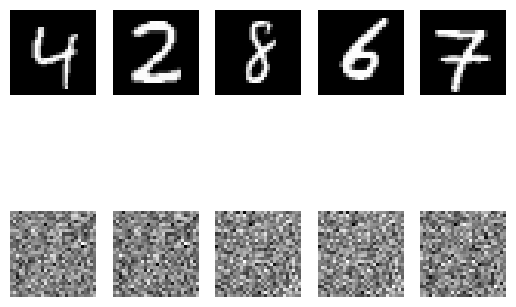

In [ ]:
# Get a batch of data
data, _ = next(iter(train_loader))
data = data.view(-1, input_dim)

# Forward through the Encoder
mu, logvar = encoder(data)

# Sample z from the approximate posterior using the reparameterization trick
z = sample(encoder, mu, logvar)

# Forward through the Decoder
reconstructed_data = decoder(z)

# Plot the original and reconstructed images
num_images = 5
for i in range(num_images):
  plt.subplot(2, num_images, i + 1)
  plt.imshow(data[i].view(28, 28).detach().numpy(), cmap='gray')
  plt.axis('off')

  plt.subplot(2, num_images, i + 1 + num_images)
  plt.imshow(reconstructed_data[i].view(28, 28).detach().numpy(), cmap='gray')
  plt.axis('off')

plt.show()


### Assignment 2

Before we can write the train loop, we need to implement the loss function. Variational autoencoders are trained by maximizing the Evidence Lower Bound (ELBO). Define the function `elbo_loss()` that calculates the loss, given a batch of images, latent distributions and reconstructions. The exact implementation will depend on the parameterization of your posterior and likelihood model. Note that if all pixels are modelled as independent, the correct, total log likelihood should be the summation of each term attributed to each pixel.

In [ ]:
def elbo_loss(x, x_recon, mu, logvar):
  """Calculates the Evidence Lower Bound (ELBO) loss.

  Args:
    x: The input batch of images.
    x_recon: The reconstructed images.
    mu: The mean of the latent distribution.
    logvar: The log variance of the latent distribution.

  Returns:
    The ELBO loss.
  """

  # Reconstruction loss (Binary Cross-Entropy)
  recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')

  # KL divergence between the approximate posterior and the prior (standard Gaussian)
  kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  # ELBO loss
  elbo = recon_loss + kl_div

  return elbo


Now implement the train loop and train both the `Encoder` and `Decoder` jointly. After a few epochs you should already see sensible reconstructions.

In [ ]:
# Define optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

# Number of training epochs
num_epochs = 10

# Train loop
for epoch in range(num_epochs):
  for batch_idx, (data, _) in enumerate(train_loader):
    data = data.view(-1, input_dim)

    # Forward pass
    mu, logvar = encoder(data)
    z = sample(encoder, mu, logvar)
    reconstructed_data = decoder(z)

    # Compute loss
    loss = elbo_loss(data, reconstructed_data, mu, logvar)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if batch_idx % 100 == 0:
      print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))


Epoch: 0 [0/60000 (0%)]	Loss: 34793.875000
Epoch: 0 [6400/60000 (11%)]	Loss: 12605.753906
Epoch: 0 [12800/60000 (21%)]	Loss: 11746.106445
Epoch: 0 [19200/60000 (32%)]	Loss: 10951.252930
Epoch: 0 [25600/60000 (43%)]	Loss: 11072.145508
Epoch: 0 [32000/60000 (53%)]	Loss: 11083.014648
Epoch: 0 [38400/60000 (64%)]	Loss: 10425.574219
Epoch: 0 [44800/60000 (75%)]	Loss: 10809.401367
Epoch: 0 [51200/60000 (85%)]	Loss: 10392.965820
Epoch: 0 [57600/60000 (96%)]	Loss: 10352.158203
Epoch: 1 [0/60000 (0%)]	Loss: 10796.289062
Epoch: 1 [6400/60000 (11%)]	Loss: 9760.443359
Epoch: 1 [12800/60000 (21%)]	Loss: 10318.847656
Epoch: 1 [19200/60000 (32%)]	Loss: 9491.662109
Epoch: 1 [25600/60000 (43%)]	Loss: 10767.618164
Epoch: 1 [32000/60000 (53%)]	Loss: 10519.779297
Epoch: 1 [38400/60000 (64%)]	Loss: 9380.486328
Epoch: 1 [44800/60000 (75%)]	Loss: 10299.691406
Epoch: 1 [51200/60000 (85%)]	Loss: 9672.517578
Epoch: 1 [57600/60000 (96%)]	Loss: 10570.689453
Epoch: 2 [0/60000 (0%)]	Loss: 9362.271484
Epoch: 2 [6400


Let's take a closer look at what the model has learnt. In theory, the likelihood model should have learnt a 2D Gaussian latent manifold for all MNIST digits. To visualize this manifold, sample latent codes on a grid centered around (0,0), and visualize the outputs of the likelihood model.

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


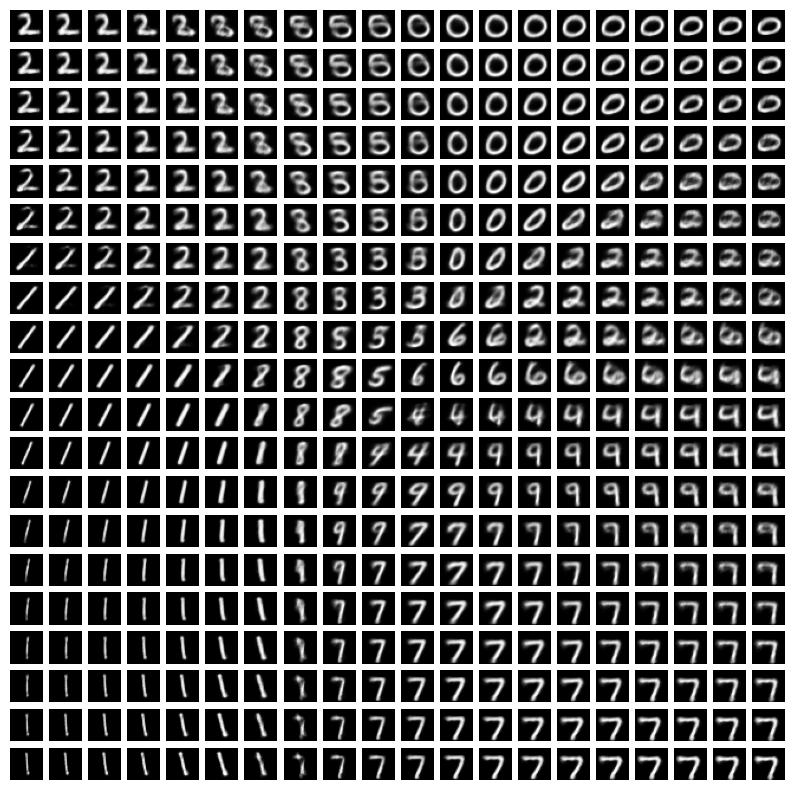

In [ ]:
# Generate a grid of latent codes
grid_size = 20
grid_x = torch.linspace(-3, 3, grid_size)
grid_y = torch.linspace(-3, 3, grid_size)
grid_z = torch.stack(torch.meshgrid(grid_x, grid_y), dim=-1).reshape(-1, 2)

# Decode the latent codes
decoded_images = decoder(grid_z)

# Plot the decoded images
fig, ax = plt.subplots(grid_size, grid_size, figsize=(10, 10))
for i in range(grid_size):
  for j in range(grid_size):
    ax[i, j].imshow(decoded_images[i * grid_size + j].view(28, 28).detach().numpy(), cmap='gray')
    ax[i, j].axis('off')

plt.show()


Similarly, we can also encode all MNIST digits from the test set using the approximate posterior model, and plot the means of the resulting posterior distributions on a scatter plot. Use the MNIST digit label as the color for each data point.

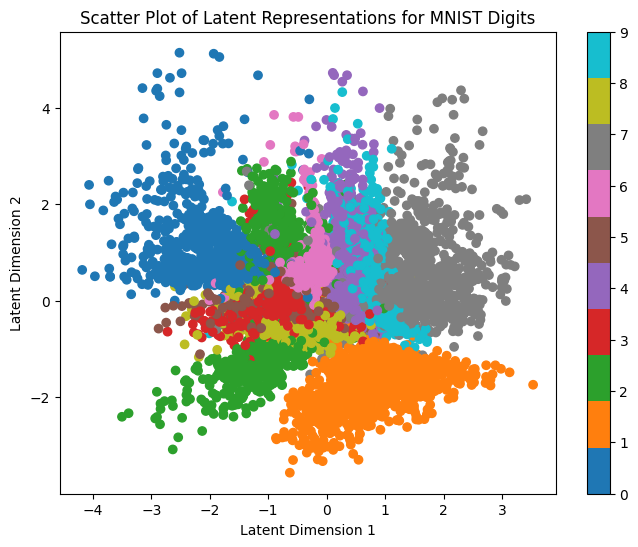

In [ ]:
# Load the MNIST test dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Encode all MNIST digits from the test set
all_mu = []
all_labels = []

with torch.no_grad():
  for data, labels in test_loader:
    data = data.view(-1, input_dim)
    mu, _ = encoder(data)
    all_mu.append(mu)
    all_labels.append(labels)

all_mu = torch.cat(all_mu, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Plot the means of the posterior distributions on a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(all_mu[:, 0], all_mu[:, 1], c=all_labels, cmap='tab10')
plt.colorbar()
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Scatter Plot of Latent Representations for MNIST Digits')
plt.show()


## The information bottleneck and $\beta$-VAE

The dimensionality of the latent code, as well as the KL term in the ELBO loss regulate the information bottleneck of the Variational Autoencoder. The $\beta$-VAE lets you explicitly tune the pressure of this bottleneck via the loss function.

### Assignment 3

Instantiate a new `Encoder` and `Decoder`, now with a larger latent dimensionality (e.g. 10 latent dimensions). Re-train such a VAE. To get an intuition on what the different latent dimensions encode, create again a grid in which you vary a single latent dimension (e.g. -3 .. 3) in each row. Also increase the capacity of the encoder and decoder by increasing the size of the hidden layers.

Epoch 0, Batch 0, Loss: 34869.17
Epoch 0, Batch 100, Loss: 12125.78
Epoch 0, Batch 200, Loss: 11882.56
Epoch 0, Batch 300, Loss: 10197.45
Epoch 0, Batch 400, Loss: 8622.76
Epoch 0, Batch 500, Loss: 8630.63
Epoch 0, Batch 600, Loss: 8513.39
Epoch 0, Batch 700, Loss: 8261.54
Epoch 0, Batch 800, Loss: 8209.73
Epoch 0, Batch 900, Loss: 7394.15
Epoch 1, Batch 0, Loss: 7922.75
Epoch 1, Batch 100, Loss: 7558.12
Epoch 1, Batch 200, Loss: 7801.55
Epoch 1, Batch 300, Loss: 7616.82
Epoch 1, Batch 400, Loss: 7414.00
Epoch 1, Batch 500, Loss: 7682.41
Epoch 1, Batch 600, Loss: 7436.53
Epoch 1, Batch 700, Loss: 7627.16
Epoch 1, Batch 800, Loss: 7168.83
Epoch 1, Batch 900, Loss: 7524.64
Epoch 2, Batch 0, Loss: 7143.77
Epoch 2, Batch 100, Loss: 7446.44
Epoch 2, Batch 200, Loss: 7581.05
Epoch 2, Batch 300, Loss: 7326.82
Epoch 2, Batch 400, Loss: 7239.52
Epoch 2, Batch 500, Loss: 7788.15
Epoch 2, Batch 600, Loss: 7546.94
Epoch 2, Batch 700, Loss: 6968.97
Epoch 2, Batch 800, Loss: 7263.98
Epoch 2, Batch 9

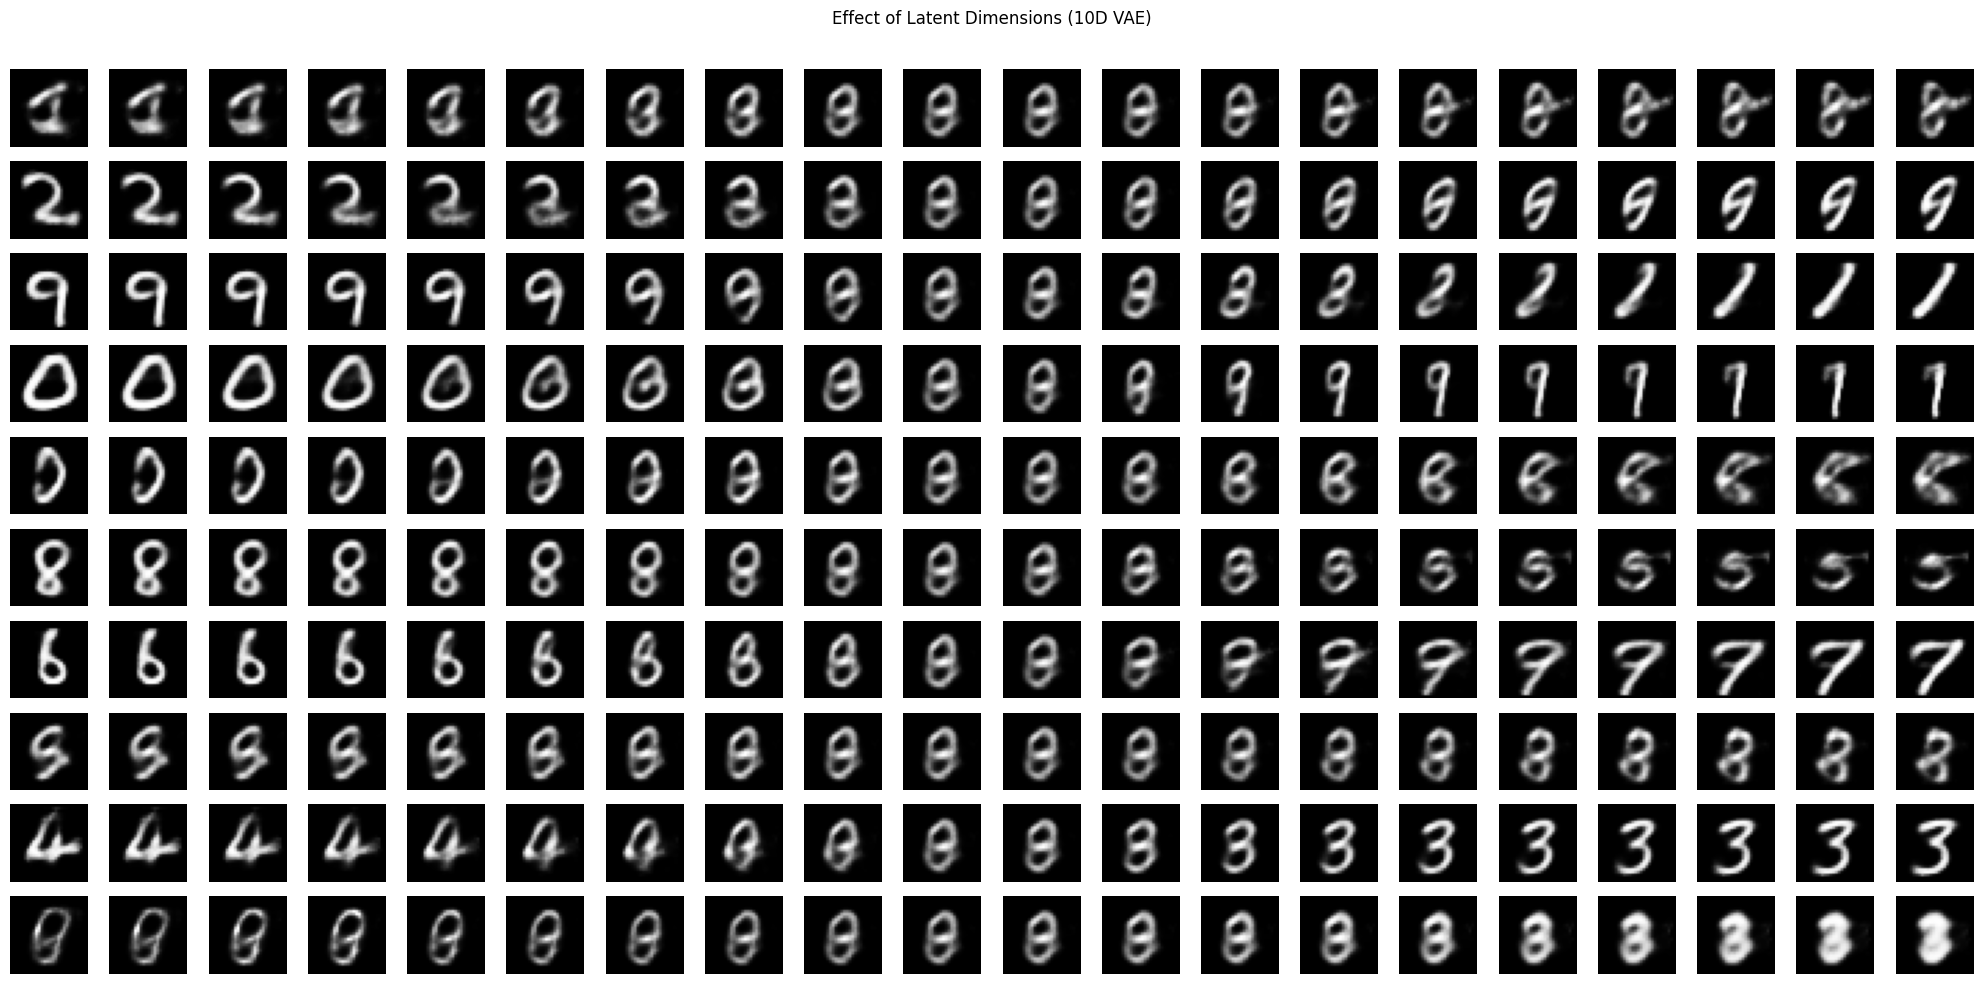

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision

# Actualized hyperparameters
input_dim = 28 * 28
hidden_dim = 512
latent_dim = 10
batch_size = 64
num_epochs = 10
learning_rate = 1e-3
grid_size = 20
grid_values = torch.linspace(-3, 3, grid_size)

# Dataset
transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#New encoder and decoder
encoder = Encoder(input_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, input_dim)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

# Train
for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim)

        mu, logvar = encoder(data)
        z = sample(encoder, mu, logvar)
        recon = decoder(z)

        loss = elbo_loss(data, recon, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.2f}")

# Visualize: ceach row = one latent dimension, from -3 to 3
grid_z = torch.zeros(grid_size * latent_dim, latent_dim)
for j in range(latent_dim):
    for i in range(grid_size):
        grid_z[j * grid_size + i, j] = grid_values[i]

decoded_images = decoder(grid_z)

fig, ax = plt.subplots(latent_dim, grid_size, figsize=(grid_size, latent_dim))
for j in range(latent_dim):
    for i in range(grid_size):
        idx = j * grid_size + i
        ax[j, i].imshow(decoded_images[idx].view(28, 28).detach().numpy(), cmap='gray')
        ax[j, i].axis('off')

plt.suptitle('Effect of Latent Dimensions (10D VAE)')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


Now change the loss function to add a $\beta$ factor for the KL term. Visualize again the reconstructions and experiment with different $\beta$ values. What is the effect of a higher / lower $\beta$. Can you explain this?

Training with beta = 0.1
Epoch: 0 [0/60000 (0%)]	Loss: 34900.000000
Epoch: 0 [6400/60000 (11%)]	Loss: 11757.399414
Epoch: 0 [12800/60000 (21%)]	Loss: 9449.106445
Epoch: 0 [19200/60000 (32%)]	Loss: 8199.416016
Epoch: 0 [25600/60000 (43%)]	Loss: 7150.727051
Epoch: 0 [32000/60000 (53%)]	Loss: 7051.337402
Epoch: 0 [38400/60000 (64%)]	Loss: 7015.771973
Epoch: 0 [44800/60000 (75%)]	Loss: 6730.916992
Epoch: 0 [51200/60000 (85%)]	Loss: 6487.972656
Epoch: 0 [57600/60000 (96%)]	Loss: 6204.093750
Epoch: 1 [0/60000 (0%)]	Loss: 6256.679688
Epoch: 1 [6400/60000 (11%)]	Loss: 6272.644043
Epoch: 1 [12800/60000 (21%)]	Loss: 6084.737793
Epoch: 1 [19200/60000 (32%)]	Loss: 5717.335938
Epoch: 1 [25600/60000 (43%)]	Loss: 5781.931152
Epoch: 1 [32000/60000 (53%)]	Loss: 6420.292969
Epoch: 1 [38400/60000 (64%)]	Loss: 5609.746094
Epoch: 1 [44800/60000 (75%)]	Loss: 5692.465332
Epoch: 1 [51200/60000 (85%)]	Loss: 5368.372559
Epoch: 1 [57600/60000 (96%)]	Loss: 5376.531250
Epoch: 2 [0/60000 (0%)]	Loss: 6012.213379
Epo

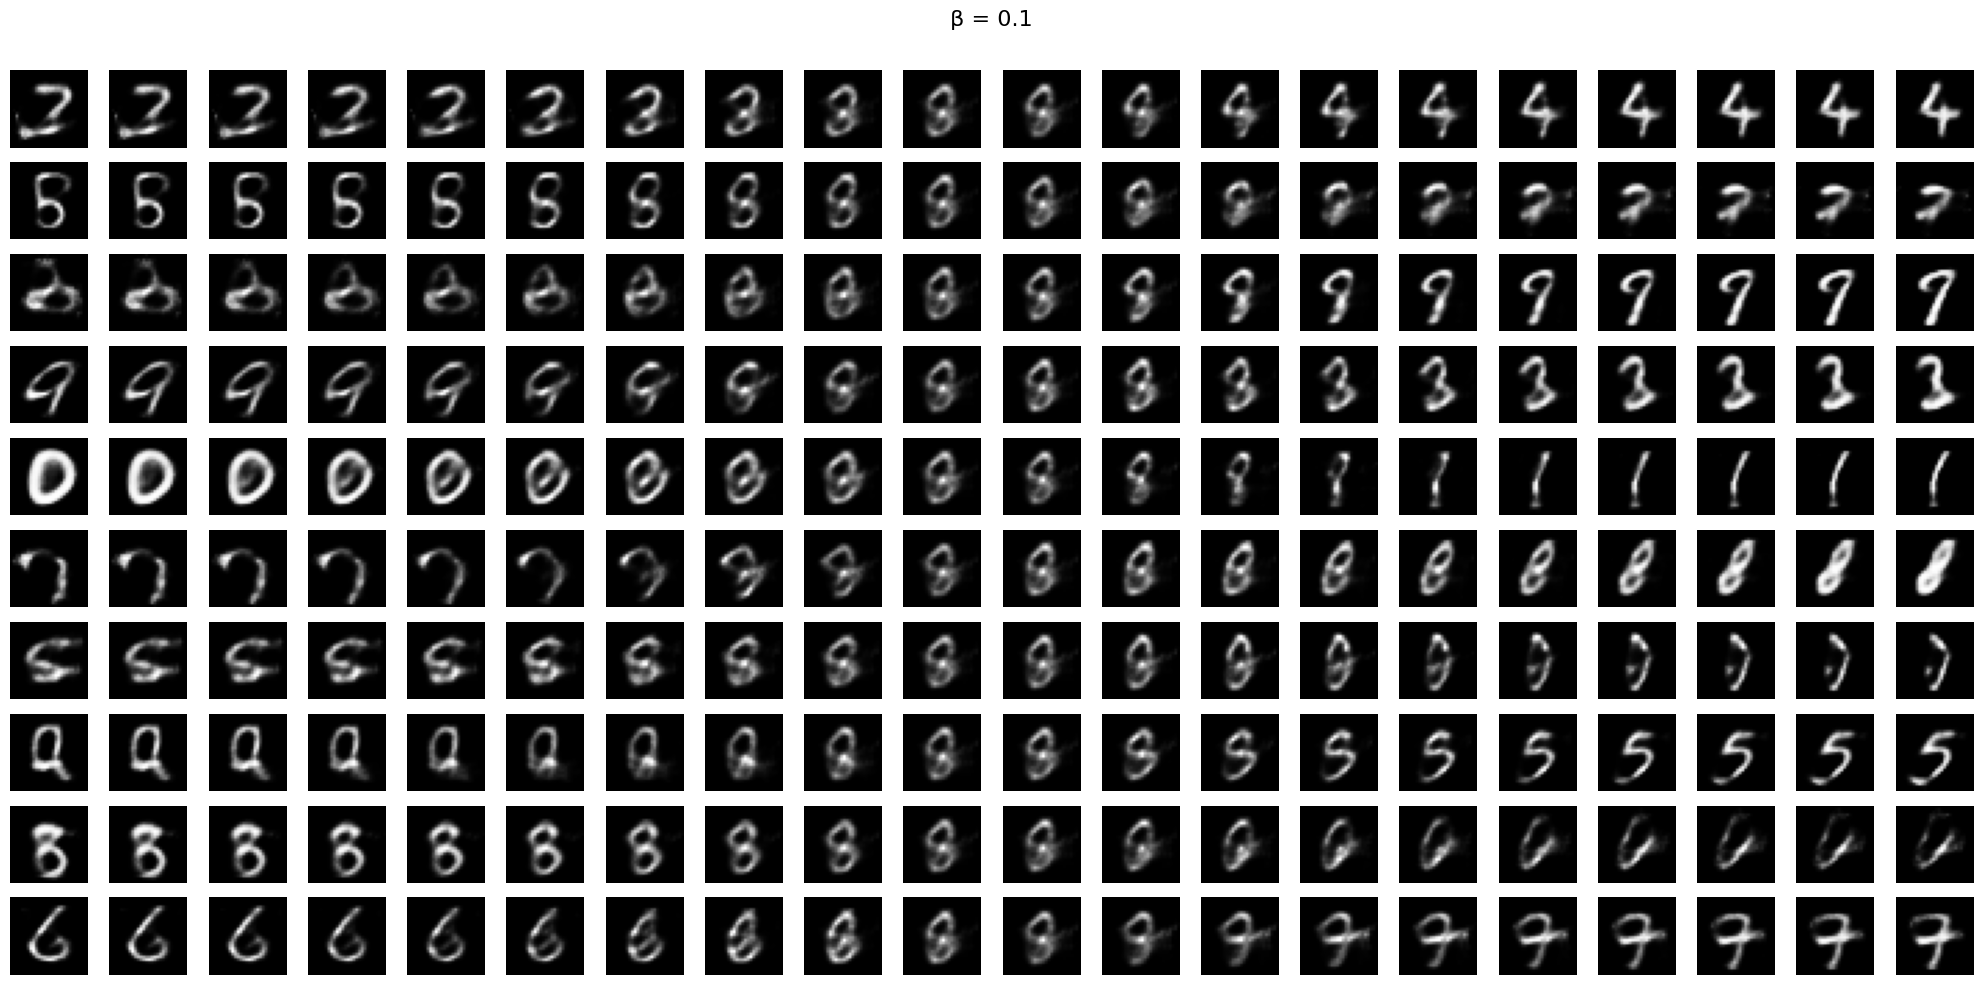

Training with beta = 1
Epoch: 0 [0/60000 (0%)]	Loss: 34920.132812
Epoch: 0 [6400/60000 (11%)]	Loss: 12232.974609
Epoch: 0 [12800/60000 (21%)]	Loss: 10935.337891
Epoch: 0 [19200/60000 (32%)]	Loss: 9493.221680
Epoch: 0 [25600/60000 (43%)]	Loss: 9330.972656
Epoch: 0 [32000/60000 (53%)]	Loss: 8683.152344
Epoch: 0 [38400/60000 (64%)]	Loss: 8567.512695
Epoch: 0 [44800/60000 (75%)]	Loss: 7875.826660
Epoch: 0 [51200/60000 (85%)]	Loss: 8034.437500
Epoch: 0 [57600/60000 (96%)]	Loss: 7845.916016
Epoch: 1 [0/60000 (0%)]	Loss: 7424.884766
Epoch: 1 [6400/60000 (11%)]	Loss: 7484.825684
Epoch: 1 [12800/60000 (21%)]	Loss: 7896.096191
Epoch: 1 [19200/60000 (32%)]	Loss: 7771.210938
Epoch: 1 [25600/60000 (43%)]	Loss: 7306.037598
Epoch: 1 [32000/60000 (53%)]	Loss: 7832.770020
Epoch: 1 [38400/60000 (64%)]	Loss: 7966.829102
Epoch: 1 [44800/60000 (75%)]	Loss: 7175.650391
Epoch: 1 [51200/60000 (85%)]	Loss: 7267.415039
Epoch: 1 [57600/60000 (96%)]	Loss: 7105.125977
Epoch: 2 [0/60000 (0%)]	Loss: 6929.293945
Epoc

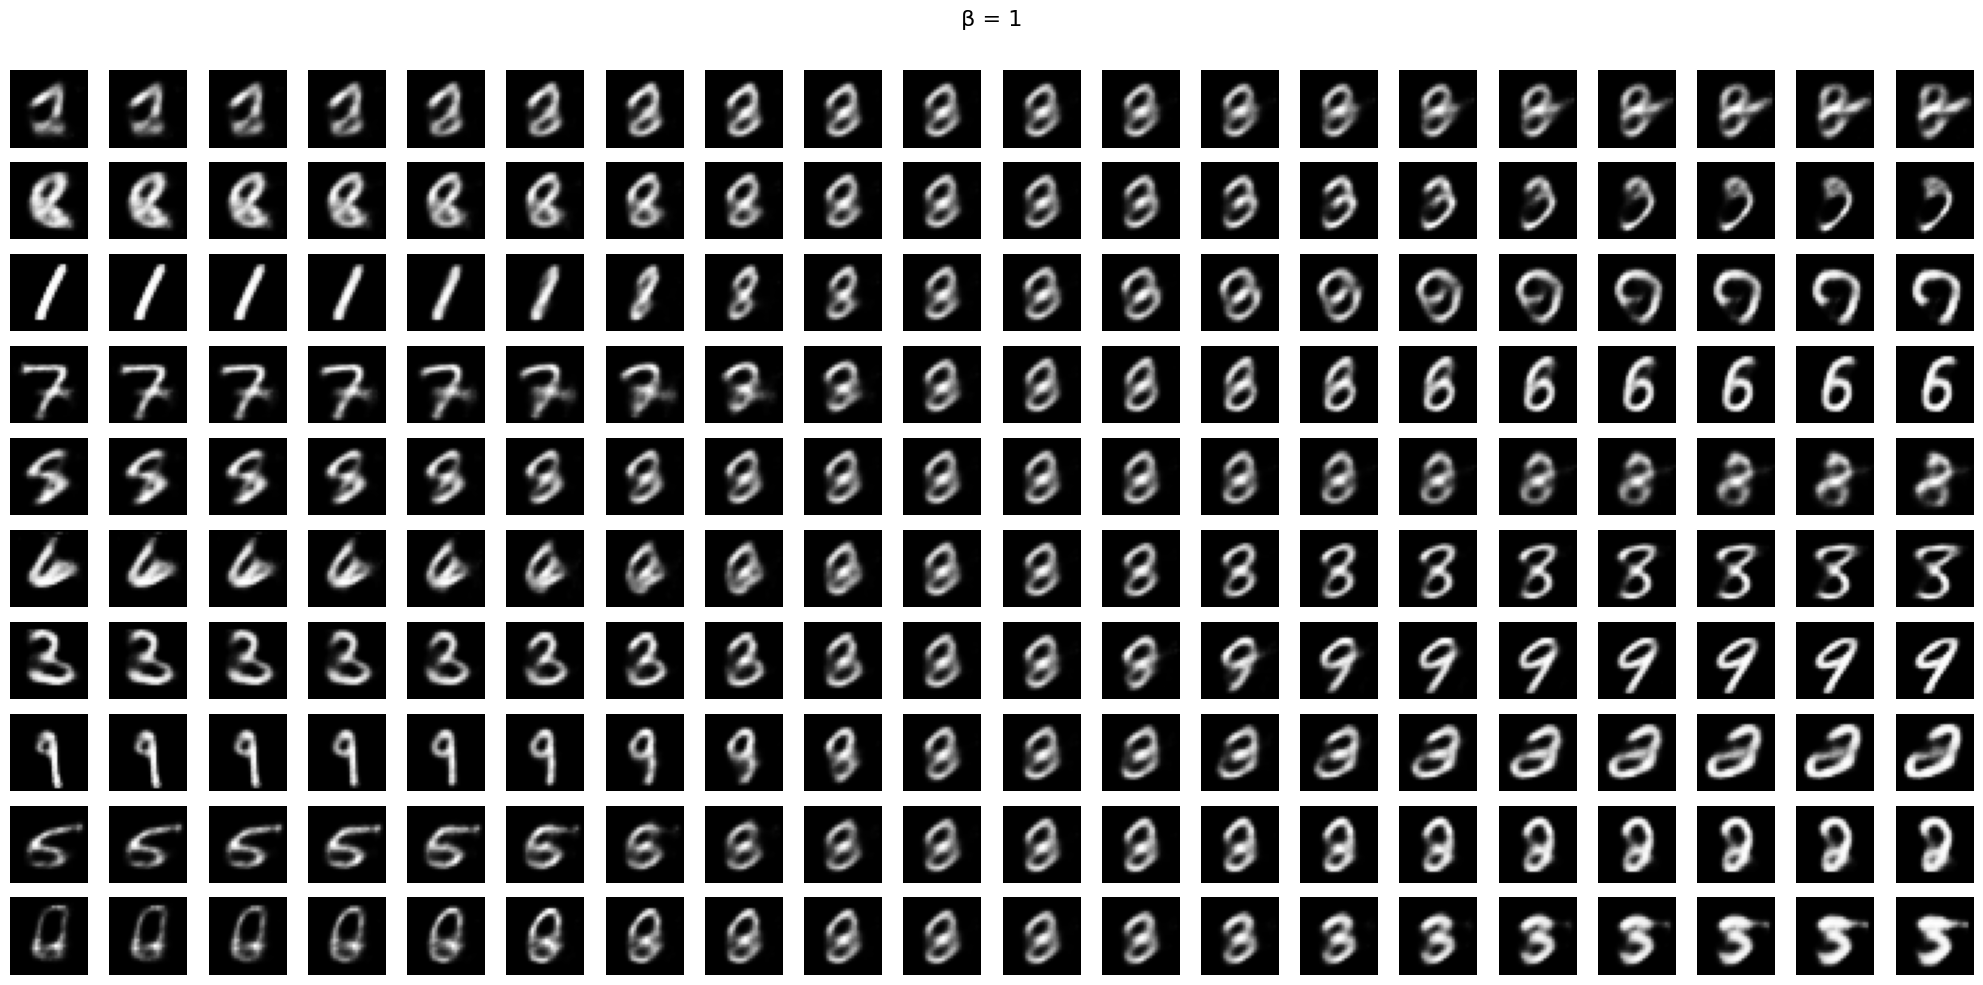

Training with beta = 10
Epoch: 0 [0/60000 (0%)]	Loss: 34848.699219
Epoch: 0 [6400/60000 (11%)]	Loss: 14112.523438
Epoch: 0 [12800/60000 (21%)]	Loss: 13386.076172
Epoch: 0 [19200/60000 (32%)]	Loss: 12425.550781
Epoch: 0 [25600/60000 (43%)]	Loss: 12359.022461
Epoch: 0 [32000/60000 (53%)]	Loss: 12263.770508
Epoch: 0 [38400/60000 (64%)]	Loss: 12869.297852
Epoch: 0 [44800/60000 (75%)]	Loss: 13077.453125
Epoch: 0 [51200/60000 (85%)]	Loss: 12336.295898
Epoch: 0 [57600/60000 (96%)]	Loss: 12662.778320
Epoch: 1 [0/60000 (0%)]	Loss: 12746.289062
Epoch: 1 [6400/60000 (11%)]	Loss: 12572.841797
Epoch: 1 [12800/60000 (21%)]	Loss: 12898.893555
Epoch: 1 [19200/60000 (32%)]	Loss: 12191.955078
Epoch: 1 [25600/60000 (43%)]	Loss: 12810.817383
Epoch: 1 [32000/60000 (53%)]	Loss: 12598.916016
Epoch: 1 [38400/60000 (64%)]	Loss: 12317.617188
Epoch: 1 [44800/60000 (75%)]	Loss: 12864.318359
Epoch: 1 [51200/60000 (85%)]	Loss: 11503.858398
Epoch: 1 [57600/60000 (96%)]	Loss: 12762.927734
Epoch: 2 [0/60000 (0%)]	Loss

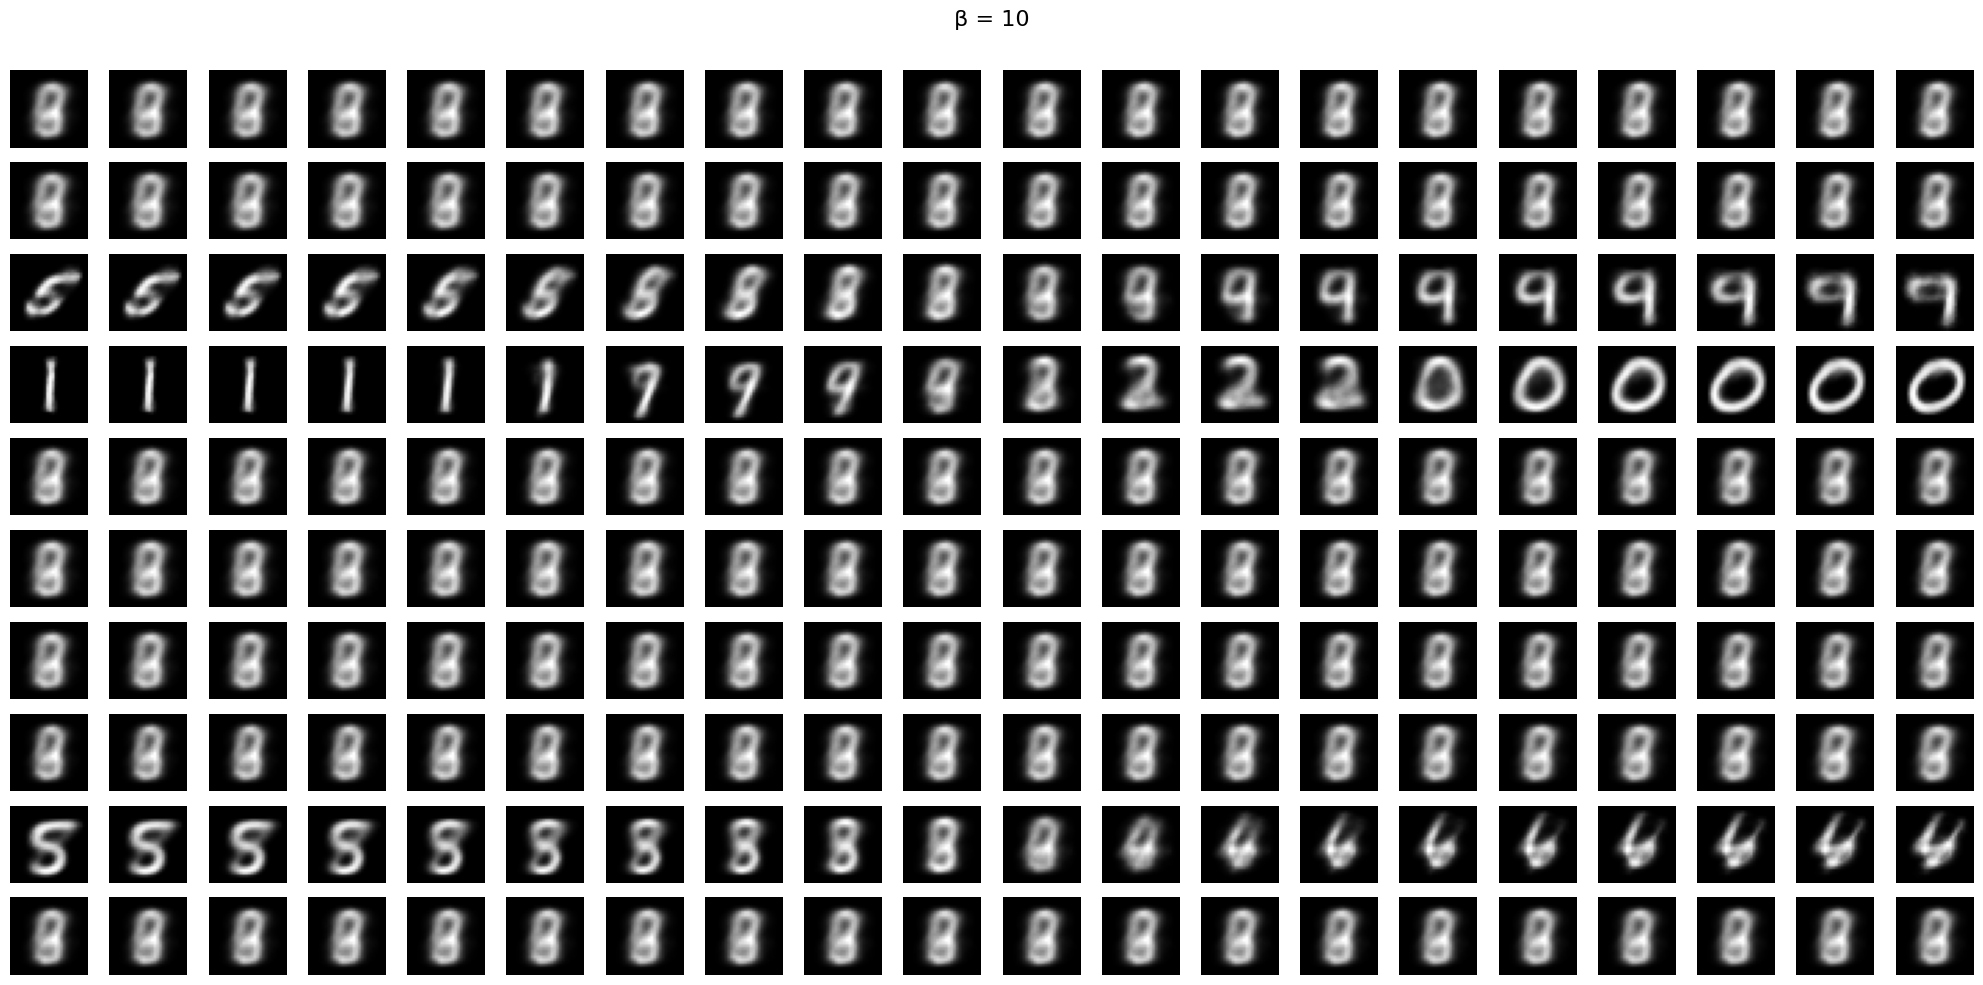

In [ ]:
def beta_elbo_loss(x, x_recon, mu, logvar, beta=1):
  """Calculates the Evidence Lower Bound (ELBO) loss with a beta factor for KL divergence.

  Args:
    x: The input batch of images.
    x_recon: The reconstructed images.
    mu: The mean of the latent distribution.
    logvar: The log variance of the latent distribution.
    beta: The beta factor for the KL divergence term.

  Returns:
    The ELBO loss.
  """

  # Reconstruction loss (Binary Cross-Entropy)
  recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')

  # KL divergence between the approximate posterior and the prior (standard Gaussian)
  kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  # ELBO loss with beta factor
  elbo = recon_loss + beta * kl_div

  return elbo


# Example of training with different beta values
beta_values = [0.1, 1, 10]  # Experiment with different beta values

for beta in beta_values:
  print(f"Training with beta = {beta}")

  # Reinitialize the encoder and decoder (or load saved models)
  encoder = Encoder(input_dim, hidden_dim, latent_dim)
  decoder = Decoder(latent_dim, hidden_dim, input_dim)

  # Define optimizer
  learning_rate = 1e-3
  optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

  # Number of training epochs
  num_epochs = 10

  # Train loop
  for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
      data = data.view(-1, input_dim)

      # Forward pass
      mu, logvar = encoder(data)
      z = sample(encoder, mu, logvar)
      reconstructed_data = decoder(z)

      # Compute loss with beta factor
      loss = beta_elbo_loss(data, reconstructed_data, mu, logvar, beta)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Print progress
      if batch_idx % 100 == 0:
        print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

  # Generate a grid of latent codes, varying a single latent dimension
  grid_z = torch.zeros(grid_size * latent_dim, latent_dim)
  for j in range(latent_dim):
      for i in range(grid_size):
          grid_z[j * grid_size + i, j] = grid_values[i]

  decoded_images = decoder(grid_z)

  fig, ax = plt.subplots(latent_dim, grid_size, figsize=(grid_size, latent_dim))
  for j in range(latent_dim):
      for i in range(grid_size):
          idx = j * grid_size + i
          ax[j, i].imshow(decoded_images[idx].view(28, 28).detach().numpy(), cmap='gray')
          ax[j, i].axis('off')

  plt.suptitle(f"β = {beta}", fontsize=16)
  plt.tight_layout()
  plt.subplots_adjust(top=0.92)
  plt.show()

Effect of higher/lower beta:

Higher beta:
- Enforces a stronger regularization on the KL divergence term.
- Pushes the approximate posterior closer to the prior (standard Gaussian).
- Results in a more disentangled latent representation, where each latent dimension captures more independent factors of variation.
- Might lead to less accurate reconstructions, as the model is forced to compress the data more aggressively.

Lower beta:
- Reduces the weight of the KL divergence term.
- Allows the approximate posterior to deviate more from the prior.
- Can lead to better reconstructions as the model has more flexibility to fit the data.
- Might result in a less disentangled latent space, where individual dimensions might capture correlated information.

Explanation:
The beta factor in the $\beta$-VAE controls the trade-off between reconstruction accuracy and the capacity of the latent space. A higher beta emphasizes the importance of the KL divergence, which encourages a more regularized latent representation. This can lead to better disentanglement of factors of variation, but might sacrifice some reconstruction quality. A lower beta focuses more on reconstruction, allowing the model to learn a more expressive latent space, which may be less disentangled but can produce better reconstructions.


## Discrete latent spaces

Until now we modelled the latent space as a Gaussian distribution. However, it is clear that at least one factor of variation (i.e. the digit) is inherintly discrete. To address this, we will now use Categorical latent distributions, and apply the reparameterization trick using the Gumbel-Softmax.

### Assignment 4

Create a new `Encoder` and `Decoder`, but now parameterize the latent distribution as a Categorical distribution with $k=10$. Reimplement the sample method to use the Gumbel-Softmax trick for reparameterization, and adjust the loss function (i.e. use a Uniform prior instead of $N(0,1)$). Again, train end-to-end and visualize the resulting latent space. If all goes well you should see that some latent dimensions actually map to a number. However it won't nicely assign each digit class to a latent dimension, due to the unsupervised training and the model capacity. To have better reconstructions, you could try more higher dimensional latent codes, for example 10 Categoricals with each $k=10$, or 100 Bernoulli variables. Another option is to have a mixed discrete and continuous latent space.

Epoch 1, Loss: 11190.11
Epoch 2, Loss: 8618.02
Epoch 3, Loss: 8071.29
Epoch 4, Loss: 7820.65
Epoch 5, Loss: 7660.36
Epoch 6, Loss: 7553.50
Epoch 7, Loss: 7475.86
Epoch 8, Loss: 7410.35
Epoch 9, Loss: 7366.95
Epoch 10, Loss: 7325.24


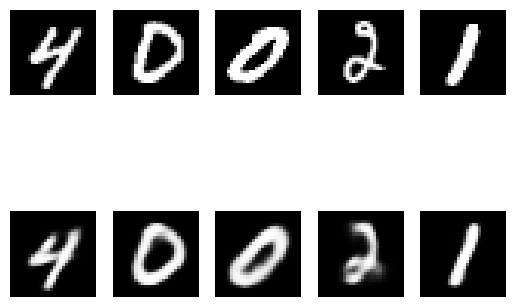

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt

# ===== Device setup =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== Encoder =====
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, k=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, latent_dim * k)
        self.latent_dim = latent_dim
        self.k = k

    def forward(self, x):
        h = F.relu(self.fc1(x))
        logits = self.fc2(h).view(-1, self.latent_dim, self.k)
        return logits

# ===== Decoder =====
class Decoder(nn.Module):
    def __init__(self, latent_dim, k, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim * k, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

# ===== Gumbel-Softmax sampling =====
def sample_gumbel(shape, device='cpu', eps=1e-20):
    U = torch.rand(shape, device=device)
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature=0.5):
    gumbel_noise = sample_gumbel(logits.size(), device=logits.device)
    y = logits + gumbel_noise
    return F.softmax(y / temperature, dim=-1)

def sample(logits, temperature=0.5):
    return gumbel_softmax_sample(logits, temperature)

# ===== Categorical ELBO Loss =====
def categorical_elbo_loss(x, x_recon, logits):
    q_y = F.softmax(logits, dim=-1)
    prior = torch.full_like(q_y, 1.0 / q_y.size(-1))  # uniform prior
    kl_div = torch.sum(q_y * (q_y.log() - prior.log()))
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')
    return recon_loss + kl_div

# ===== Training function =====
def train(encoder, decoder, train_loader, optimizer, epoch):
    encoder.train()
    decoder.train()
    total_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28 * 28).to(device)
        logits = encoder(data)
        q_y = sample(logits, temperature=0.5)
        z_flat = q_y.view(q_y.size(0), -1)
        x_recon = decoder(z_flat)

        loss = categorical_elbo_loss(data, x_recon, logits)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader):.2f}")

# ===== Hyperparameters =====
input_dim = 28 * 28
hidden_dim = 256
latent_dim = 10
k = 10
batch_size = 64
epochs = 10
learning_rate = 1e-3

# ===== Model and data setup =====
encoder = Encoder(input_dim, hidden_dim, latent_dim, k).to(device)
decoder = Decoder(latent_dim, k, hidden_dim, input_dim).to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ===== Training loop =====
for epoch in range(1, epochs + 1):
    train(encoder, decoder, train_loader, optimizer, epoch)

# ===== Reconstruction visualization =====
encoder.eval()
decoder.eval()
data, _ = next(iter(train_loader))
data = data.view(-1, 28 * 28).to(device)

with torch.no_grad():
    logits = encoder(data)
    q_y = sample(logits, temperature=0.5)
    z_flat = q_y.view(q_y.size(0), -1)
    x_recon = decoder(z_flat)

# ===== Plot original and reconstructed images =====
num_images = 5
for i in range(num_images):
    plt.subplot(2, num_images, i + 1)
    plt.imshow(data[i].view(28, 28).cpu().numpy(), cmap='gray')
    plt.axis('off')

    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(x_recon[i].view(28, 28).cpu().numpy(), cmap='gray')
    plt.axis('off')

plt.show()

## Closing remarks

In this Lab session we've experimented with VAE's on the MNIST dataset. We've used a simple fully connected encoder and decoder architecture. In order to get better results, it might be worthwhile exploring other architectures, in particular convolutional neural networks for encoding and decoding images. You can also easily test this on more compelling datasets that are available in `torchvision`, for example CelebA or others.

In this section we explored the use of a VAe with a convolutional encoder and a convolutional decoder. The dataset is used is _CIFAR-10_. The _CIFAR-10_ dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.

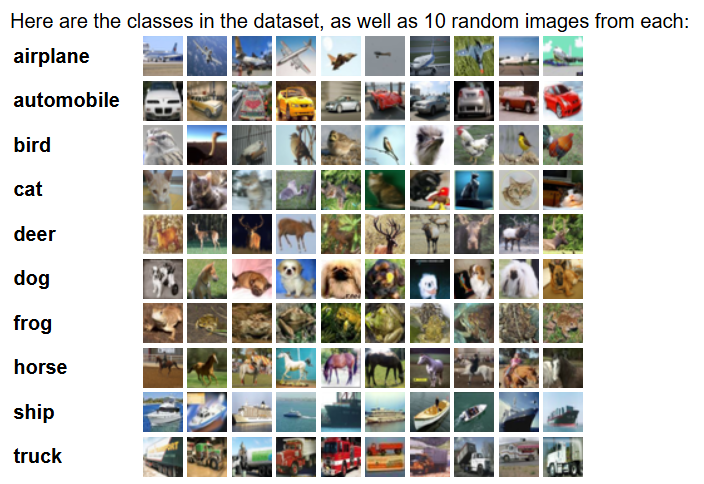

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# General configurations
latent_dim = 128
batch_size = 64
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

cifar = CIFAR10(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(cifar, batch_size=64, shuffle=True)

100%|██████████| 170M/170M [00:03<00:00, 43.8MB/s]


In [ ]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, 2, 1)   # 32 → 16
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1)  # 16 → 8
        self.conv3 = nn.Conv2d(64, 128, 4, 2, 1) # 8 → 4

        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        return self.fc_mu(x), self.fc_logvar(x)

class ConvDecoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)

        self.deconv1 = nn.ConvTranspose2d(128, 64, 4, 2, 1)  # 4 → 8
        self.deconv2 = nn.ConvTranspose2d(64, 32, 4, 2, 1)   # 8 → 16
        self.deconv3 = nn.ConvTranspose2d(32, 3, 4, 2, 1)    # 16 → 32

    def forward(self, z):
        x = self.fc(z).view(-1, 128, 4, 4)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        return torch.tanh(self.deconv3(x))

In [ ]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def elbo_loss(x, x_recon, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [ ]:
encoder = ConvEncoder(latent_dim).to(device)
decoder = ConvDecoder(latent_dim).to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for epoch in range(epochs):
    encoder.train()
    decoder.train()
    total_loss = 0

    for batch, _ in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        mu, logvar = encoder(batch)
        z = reparameterize(mu, logvar)
        recon = decoder(z)
        loss = elbo_loss(batch, recon, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, ELBO Loss: {total_loss / len(loader.dataset):.4f}")

Epoch 1, ELBO Loss: 298.0536
Epoch 2, ELBO Loss: 211.6610
Epoch 3, ELBO Loss: 201.0800
Epoch 4, ELBO Loss: 196.7459
Epoch 5, ELBO Loss: 194.0193
Epoch 6, ELBO Loss: 192.1252
Epoch 7, ELBO Loss: 190.8821
Epoch 8, ELBO Loss: 189.8163
Epoch 9, ELBO Loss: 189.0301
Epoch 10, ELBO Loss: 188.1328
Epoch 11, ELBO Loss: 187.5807
Epoch 12, ELBO Loss: 187.0009
Epoch 13, ELBO Loss: 186.4921
Epoch 14, ELBO Loss: 186.1794
Epoch 15, ELBO Loss: 185.8749
Epoch 16, ELBO Loss: 185.4139
Epoch 17, ELBO Loss: 185.1472
Epoch 18, ELBO Loss: 184.7524
Epoch 19, ELBO Loss: 184.6542
Epoch 20, ELBO Loss: 184.3090
Epoch 21, ELBO Loss: 184.1996
Epoch 22, ELBO Loss: 183.8407
Epoch 23, ELBO Loss: 183.7122
Epoch 24, ELBO Loss: 183.6198
Epoch 25, ELBO Loss: 183.4895
Epoch 26, ELBO Loss: 183.2492
Epoch 27, ELBO Loss: 183.1977
Epoch 28, ELBO Loss: 183.0096
Epoch 29, ELBO Loss: 182.8560
Epoch 30, ELBO Loss: 182.7834
Epoch 31, ELBO Loss: 182.6784
Epoch 32, ELBO Loss: 182.5915
Epoch 33, ELBO Loss: 182.4540
Epoch 34, ELBO Loss

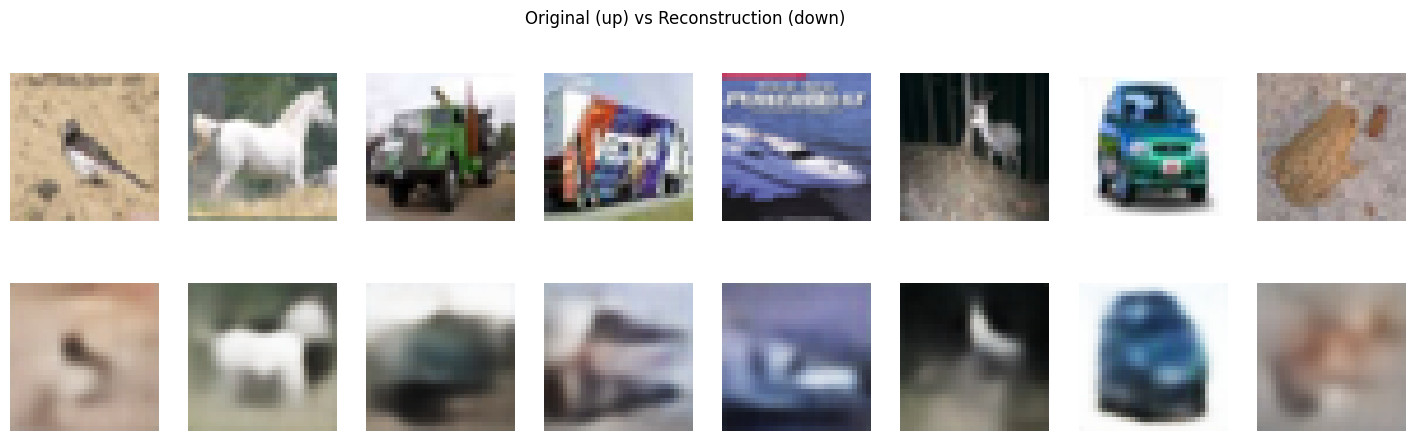

In [ ]:
def visualize_reconstructions():
    encoder.eval()
    decoder.eval()
    imgs, _ = next(iter(loader))
    imgs = imgs[:8].to(device)

    with torch.no_grad():
        mu, logvar = encoder(imgs)
        z = reparameterize(mu, logvar)
        recon = decoder(z)

    imgs = imgs.cpu()
    recon = recon.cpu()

    fig, axes = plt.subplots(2, 8, figsize=(18, 5))
    for i in range(8):
        orig_img = imgs[i].permute(1, 2, 0) * 0.5 + 0.5
        recon_img = recon[i].permute(1, 2, 0) * 0.5 + 0.5

        orig_img = orig_img.clamp(0, 1).numpy()
        recon_img = recon_img.clamp(0, 1).numpy()

        axes[0, i].imshow(orig_img)
        axes[0, i].axis("off")
        axes[1, i].imshow(recon_img)
        axes[1, i].axis("off")

    plt.suptitle("Original (up) vs Reconstruction (down)")
    plt.show()

visualize_reconstructions()

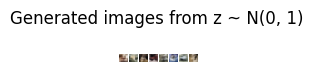

In [ ]:
def generate_new_images(n=8):
    decoder.eval()
    with torch.no_grad():
        z = torch.randn(n, latent_dim).to(device)
        generated = decoder(z).cpu()

    fig, axes = plt.subplots(1, n, figsize=(1, 1))
    for i in range(n):
        img = generated[i].permute(1, 2, 0) * 0.5 + 0.5
        axes[i].imshow(img)
        axes[i].axis("off")
    plt.suptitle("Generated images from z ~ N(0, 1)")
    plt.show()

generate_new_images()

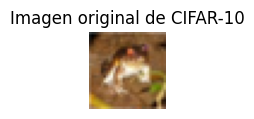

In [ ]:
import matplotlib.pyplot as plt

img, _ = cifar[0]
img = img.permute(1, 2, 0) * 0.5 + 0.5  # desnormaliza
plt.figure(figsize=(1, 1))
plt.imshow(img)
plt.axis('off')
plt.title("Original image from CIFAR-10")
plt.show()

This visual blur is not a problem with the model or reconstruction, but rather a natural consequence of displaying small images at large sizes. Reducing the display size (figsize) makes the images look sharper and closer to their intended resolution.